In [12]:
import pandas as pd 
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.3)
    Q3 = df[column].quantile(0.7)
    IQR = Q3 - Q1  
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered



In [13]:
#TASK 2

penguins=pd.read_csv('penguins.csv')
numerical_columns = penguins.select_dtypes(include=['float64', 'int64']).columns
categorical_columns= penguins.select_dtypes(include=['object']).columns

for col in numerical_columns:
    penguins[col] = penguins[col].fillna(penguins[col].mean())
for col in categorical_columns:
    penguins[col] = penguins[col].fillna(penguins[col].mode()[0])

penguins['species'] = penguins['species'].str.capitalize()
penguins['island'] = penguins['island'].str.capitalize()
penguins['gender'] = penguins['gender'].str.capitalize()
columns_to_check = ['flipper_length_mm', 'body_mass_g', 'bill_depth_mm', 'bill_length_mm', 'average sleep duration', 'calorie requirement', 'year']

for column in columns_to_check:
    penguins = remove_outliers(penguins, column)

columns_to_normalize = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'calorie requirement', 'average sleep duration',]
min_values = penguins[columns_to_normalize].min()
max_values = penguins[columns_to_normalize].max()
for col in columns_to_normalize:
    penguins[col] = (penguins[col] - min_values[col]) / (max_values[col] - min_values[col])



print(penguins.shape)
Y='island'
penguins['gender'] = penguins['gender'].apply(lambda x: 1 if x == 'Male' else 0)
penguins['island'] = penguins['island'].apply(lambda x: 1 if x == 'Torgersen' else 0)
penguins['species']= penguins['species'].astype('category').cat.codes

penguins=penguins.sort_values('bill_depth_mm')

print(penguins['island'].unique())

Y = penguins['island'].values  #target = island
X = penguins.drop(columns=['island'])
X = (X - X.mean(axis=0)) / X.std(axis=0)
print(X.head())
print(X.shape)
Y = Y.reshape(-1, 1)

(323, 10)
[0 1]
      species  calorie requirement  average sleep duration  bill_length_mm  \
176  1.224329            -0.777902               -0.643157       -0.191492   
152  1.224329             1.235618                0.677223        0.399186   
200  1.224329             1.339961               -0.643157        0.177682   
160  1.224329             1.329620               -0.203031       -0.117657   
157  1.224329             1.150077               -1.083284        0.473021   

     bill_depth_mm  flipper_length_mm  body_mass_g   gender      year  
176      -2.093775           0.998592     0.998034 -1.05246 -1.296038  
152      -2.042535           0.713732     0.367179 -1.05246 -1.296038  
200      -1.991295           0.856162     1.124205 -1.05246 -0.061298  
160      -1.940055           0.571302     0.241008 -1.05246 -1.296038  
157      -1.888815           0.642517     0.430265 -1.05246 -1.296038  
(323, 9)


In [14]:
import random
N = X.shape[0]
indices = list(range(N))
random.seed(42)
random.shuffle(indices)

train_size = int(0.8 * N)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train = X.iloc[train_indices]
Y_train = Y[train_indices]
X_test = X.iloc[test_indices]
Y_test = Y[test_indices]

print("X_train Shape: ", X_train.shape," Y_train Shape: ",Y_train.shape)
print("X_test Shape: ",X_test.shape," Y_test Shape: ",Y_test.shape)  


X_train Shape:  (258, 9)  Y_train Shape:  (258, 1)
X_test Shape:  (65, 9)  Y_test Shape:  (65, 1)


In [15]:

class LogitRegression():
    def __init__(self, learning_rate=0.005, iterations=50000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def cost(self, h, y):
        m = len(y)
        return (-1 / m) * np.sum(y * np.log(h + 1e-10) + (1 - y) * np.log(1 - h + 1e-10))

    def gradient_descent(self, X, y, h):
        m = len(y)
        delta = h - y.flatten()
        dW = (1 / m) * np.dot(X.T, delta)
        db = (1 / m) * np.sum(delta)
        self.w -= self.learning_rate * dW
        self.b -= self.learning_rate * db

    def fit(self, X, y):
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float).flatten()

        assert X.ndim == 2
        assert y.ndim == 1
        assert X.shape[0] == y.shape[0]

        self.w = np.random.uniform(0, 1, X.shape[1])
        self.b = 0
        self.losses = []

        for i in range(self.iterations):
            z = np.dot(X, self.w) + self.b
            h = self.sigmoid(z)

            loss = self.cost(h, y)
            self.losses.append(loss)

            self.gradient_descent(X, y, h)

            if i % 100 == 0:
                print(f'Iteration {i}, Loss: {loss}')

    def predict(self, X):
        z = np.dot(X, self.w) + self.b
        h = self.sigmoid(z)
        return np.where(h >= 0.5, 1, 0)

    def save_weights(self, file_name="model_weights.pkl"):
        with open(file_name, 'wb') as file:
            pickle.dump({'weights': self.w, 'bias': self.b}, file)
        print(f"Weights and bias saved to {file_name}")


In [16]:
model = LogitRegression()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

Iteration 0, Loss: 1.7830705679213479
Iteration 100, Loss: 1.3259799117368405
Iteration 200, Loss: 0.9889842845977235
Iteration 300, Loss: 0.7743756097295064
Iteration 400, Loss: 0.6486541832626855
Iteration 500, Loss: 0.5736550849767046
Iteration 600, Loss: 0.5252493264731305
Iteration 700, Loss: 0.49127746837265385
Iteration 800, Loss: 0.4658485863421834
Iteration 900, Loss: 0.44595302418890714
Iteration 1000, Loss: 0.4299125936424959
Iteration 1100, Loss: 0.41670363401212246
Iteration 1200, Loss: 0.40565220778426964
Iteration 1300, Loss: 0.3962879884539619
Iteration 1400, Loss: 0.388268612448084
Iteration 1500, Loss: 0.3813372388721168
Iteration 1600, Loss: 0.37529689666146626
Iteration 1700, Loss: 0.3699939719117541
Iteration 1800, Loss: 0.3653070401214905
Iteration 1900, Loss: 0.3611390269030971
Iteration 2000, Loss: 0.3574115508958494
Iteration 2100, Loss: 0.3540607557265434
Iteration 2200, Loss: 0.3510341892626565
Iteration 2300, Loss: 0.3482884365024558
Iteration 2400, Loss: 0.

In [17]:
y_pred=y_pred.reshape(-1,1)
correct_predictions = np.sum(y_pred == Y_test)

accuracy = correct_predictions / len(Y_test) * 100
print(accuracy)
model.save_weights('Pavithran_Assignment1_part2.pkl')

90.76923076923077
Weights and bias saved to Pavithran_Assignment1_part2.pkl


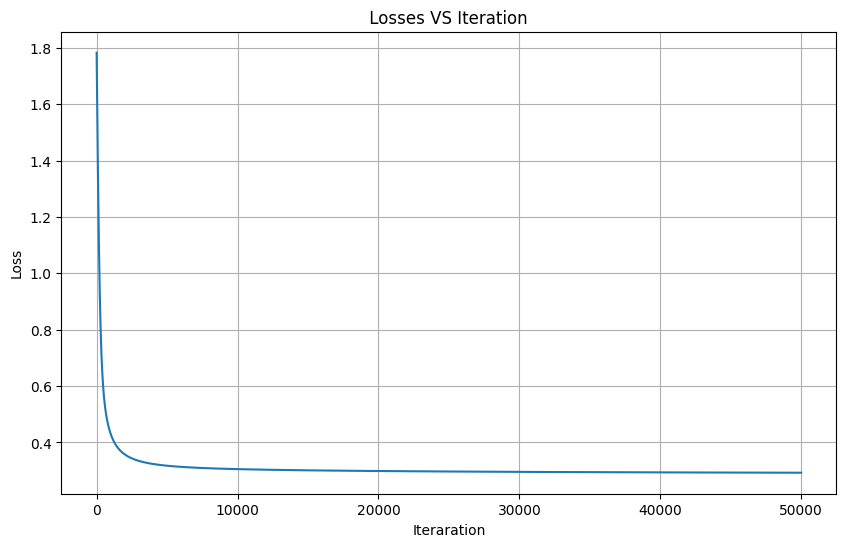

In [18]:
plt.figure(figsize=(10,6))
plt.plot(model.losses)
plt.xlabel('Iteraration')
plt.ylabel('Loss')
plt.title(' Losses VS Iteration ')
plt.grid()
plt.show()